In [1]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler

In [2]:
# II. Second try with IRS dataset

In [4]:
 #The IRS (i.e Internal Revenue Service) website contains a dataset of all the migrations between county. We can access data about the migration inflow or the migration outflaw of each county. 
#We are more interested by the inflow migration dataset which describes what kind of immigration a county was subject to.
#The IRS allow us to have access to 3 different type of migration inflow for each county : 
#1. People who migrated and that are US citizen 
#2. People who migrated and that are not US citizen 
#3. The total number of people who migrated

#Each of this flow is caracterized by 3 variables : 
#1. `returns`: the number of people who moved and payed taxes
#2. `exemption`: the number of people who moved and did not pay taxes
#3. `agi`: the average salary of the people who moved 

#To complete this dataset, we found a dataset that compiles the results of the 2016 Presidential Election by counties. The dataset comes from The Guardian (a British Newspaper). 

## II.1 Extract, clean the data 
#First, load the county migration dataset and clean it. 

In [5]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """  
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

In [6]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )
print(df_migrations)

       y2_statefips  y2_countyfips  y1_statefips  y1_countyfips y1_state  \
0                 1              0            96              0       AL   
1                 1              0            97              0       AL   
2                 1              0            97              1       AL   
3                 1              0            97              3       AL   
4                 1              0            98              0       AL   
...             ...            ...           ...            ...      ...   
86325            56             45            59              0       DS   
86326            56             45            59              1       DS   
86327            56             45            59              3       DS   
86328            56             45            59              5       DS   
86329            56             45            59              7       DS   

                         y1_countyname      n1      n2      agi  
0       Total Migrati

In [7]:
# load the data
df_migrations = pd.read_csv("./NTDS_Data/countyinflow1516.csv" )

# keep only summury information of each county
df_migrations = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration")]

# create the combined fips county number 
df_migrations['statefips_str'] = df_migrations['y2_statefips'].apply(lambda x : str(x).zfill(2))
df_migrations['countyfips_str'] = df_migrations['y2_countyfips'].apply(lambda x : str(x).zfill(3))
df_migrations['combined_fips'] = df_migrations['statefips_str'].apply(lambda x: x.lstrip('0')) + df_migrations['countyfips_str']

# drop useless information 
df_migrations = df_migrations.drop(columns=["y2_statefips", "y2_countyfips", "y1_statefips", "y1_countyfips", "y1_state", "statefips_str", "countyfips_str"])

# seperate each possible migration into three dataframe 
df_migration_total = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US and Foreign")]
df_migrations['y1_countyname'] = df_migrations['y1_countyname'].apply(lambda x : x if x.find("County Total Migration-US and Foreign") == -1 else "County Total Migration Both")
df_migration_us = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-US")]
df_migration_for = df_migrations[df_migrations['y1_countyname'].str.contains("County Total Migration-Foreign")]

# drop the name of the column 
df_migration_total = df_migration_total.drop(columns=["y1_countyname"])
df_migration_us = df_migration_us.drop(columns=["y1_countyname"])
df_migration_for = df_migration_for.drop(columns=["y1_countyname"])

# remove nodes where data is undefined undefined data by zero
df_migration_total = df_migration_total[df_migration_total['n1'] != -1]
df_migration_us = df_migration_us[df_migration_us['n1'] != -1]
df_migration_for = df_migration_for[df_migration_for['n1'] != -1]

# convert combined fips to int64
df_migration_total['combined_fips'] = df_migration_total['combined_fips'].astype('int64')
df_migration_us['combined_fips'] = df_migration_us['combined_fips'].astype('int64')
df_migration_for['combined_fips'] = df_migration_for['combined_fips'].astype('int64')

In [8]:
df_presidential_result = pd.read_csv("./NTDS_Data/2016_US_County_Level_Presidential_Results.csv" )
df_presidential_result = df_presidential_result.drop(columns=["Unnamed: 0","votes_dem", "votes_gop", "total_votes", "diff", "per_point_diff", "state_abbr", "county_name"])
print(df_presidential_result)

       per_dem   per_gop  combined_fips
0     0.377159  0.528870           2013
1     0.377159  0.528870           2016
2     0.377159  0.528870           2020
3     0.377159  0.528870           2050
4     0.377159  0.528870           2060
...        ...       ...            ...
3136  0.194046  0.729428          56037
3137  0.600608  0.321945          56039
3138  0.149261  0.764187          56041
3139  0.143203  0.783580          56043
3140  0.088182  0.869226          56045

[3141 rows x 3 columns]


In [9]:
# merge the two dataset and drop useless column, add a new column winner 
df_merged_total = pd.merge(df_migration_total, df_presidential_result, on="combined_fips", how='inner')
df_merged_us = pd.merge(df_migration_us, df_presidential_result, on="combined_fips", how='inner')
df_merged_for = pd.merge(df_migration_for, df_presidential_result, on="combined_fips", how='inner')
df_merged_total['difference'] = df_merged_total['per_dem'] - df_merged_total['per_gop']
df_merged_us['difference'] = df_merged_us['per_dem'] - df_merged_total['per_gop']
df_merged_for['difference'] = df_merged_for['per_dem'] - df_merged_total['per_gop']
df_merged_total['winner'] = df_merged_total['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_us['winner'] = df_merged_us['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_for['winner'] = df_merged_for['difference'].apply(lambda x : -1 if x > 0 else 1)
df_merged_total = df_merged_total.drop(columns=['difference'])
df_merged_us = df_merged_us.drop(columns=['difference'])
df_merged_for = df_merged_for.drop(columns=['difference'])

In [10]:
labels=df_merged_total['winner']
X_total = df_merged_total.drop(columns=['combined_fips', 'per_dem', 'per_gop', 'winner'])
nodes_total = df_merged_total.drop(columns=['n1', 'n2', 'agi', 'per_dem', 'per_gop']).values
#dfmax=abs(X_total['agi']).max()
#X_total['agi']=X_total['agi'].divide(dfmax)
X_total['agi'] = (X_total['agi'] - X_total['agi'].mean()) / X_total['agi'].std()
X_total['prop_ret/exempt'] = X_total['n1'] / X_total['n2']
#dfmax_1=abs(X_total['prop_ret/exempt']).max()
#X_total['prop_ret/exempt']=X_total['prop_ret/exempt'].divide(dfmax_1)
X_total = X_total.drop(columns=['n1', 'n2'])
print(X_total)

           agi  prop_ret/exempt
0    -0.127069         0.432270
1     0.449295         0.496523
2    -0.281678         0.468787
3    -0.279707         0.434731
4    -0.228247         0.455167
...        ...              ...
2958 -0.202587         0.462637
2959  0.156933         0.655844
2960 -0.255846         0.416878
2961 -0.294052         0.451087
2962 -0.293956         0.521341

[2963 rows x 2 columns]


In [11]:
distances = pdist(X_total.values, metric='euclidean')

#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
#weights = np.exp(-distances**2 / kernel_width**2)
#adjacency_full = squareform(weights)

0.5284353963018223


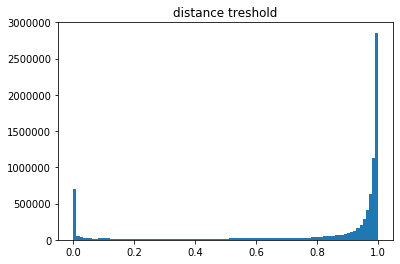

1428932
#nodes=  2963
#compo=  56
#nodes in giant component=  2883
percentage of nodes in main component=  0.9730003374957813


In [12]:
#informatons over connectivity of main component 
adjacency = epsilon_similarity_graph(X_total, sigma=kernel_width, epsilon=0.99)
graph=nx.from_numpy_matrix(adjacency)
print(graph.number_of_edges())
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=max(nx.connected_components(graph), key = len)
print("#nodes in giant component= ", len(list_comp))
print("percentage of nodes in main component= ",len(list_comp)/adjacency.shape[0])

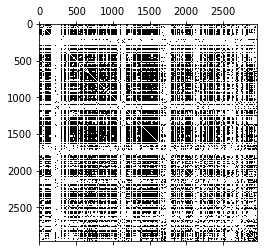

In [13]:
plt.spy(adjacency)
plt.show()

In [14]:
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
X_total_conn=X_total.iloc[list(list_comp)]
A =(nx.adjacency_matrix(conn_graph))

In [15]:
adj=nx.to_numpy_matrix(conn_graph)

In [16]:
n_nodes =  adj.shape[0]
n_edges = int(adj.sum() // 2)
print(n_nodes)
print(n_edges)
print("#compo= ",nx.number_connected_components(conn_graph))

2883
1423288
#compo=  1


In [17]:
laplacian_combinatorial=nx.linalg.laplacian_matrix(conn_graph, nodelist=None, weight='weight')
laplacian_normalized=nx.linalg.laplacianmatrix.normalized_laplacian_matrix(conn_graph, nodelist=None, weight='weight')

laplacian = laplacian_normalized

In [18]:
import scipy.sparse.linalg
e, U= sparse.linalg.eigsh(laplacian.toarray(),k=2883)
#e, U=np.linalg.eigh(laplacian)

C:\Users\fatimzzahra moujrid\.conda\envs\test\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:1572: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


In [19]:
a=(np.sum(adj,1))
a_sq=np.power(a, -0.5)
d=np.zeros((n_nodes,n_nodes))
d[np.arange(d.shape[0]), np.arange(d.shape[1])] = (a_sq.T)
D_norm=d
print(d)

[[0.08932091 0.         0.         ... 0.         0.         0.        ]
 [0.         0.20456106 0.         ... 0.         0.         0.        ]
 [0.         0.         0.02496669 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.03361241 0.         0.        ]
 [0.         0.         0.         ... 0.         0.02681793 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02558194]]


In [20]:
network_emb = D_norm @ U[:,[1,3]]
emb_x = network_emb[:,0]
emb_y = network_emb[:,1]

In [21]:
mn_ratio = 0.3
w = np.random.binomial(n=1, p=mn_ratio, size=n_nodes)
m = sum(w) # Number of measurements
print('Sampled {} out of {} nodes'.format(m, n_nodes))

Sampled 880 out of 2883 nodes


In [22]:
#labels=nodes_total[:,1]
labels_conn=np.array(labels[list(list_comp)])
subsampled = labels_conn*w
subsampled.shape


(2883,)

In [23]:
def GFT(x):
    return U.T @ x

def iGFT(x):
    return U @ x

In [24]:
def heat_kernel(e, t):
    return np.exp(-t * e)
def graph_filter(x, kernel, **kwargs):
    return iGFT(kernel(e, **kwargs) * GFT(x))

In [25]:
graph = nx.from_numpy_matrix(adj)
coords = nx.spring_layout(graph) # Force-directed layout.

In [26]:
def coplot_network_signal(signal, title='Signal = ...'):
    '''
    Plots a signal on a graph using both a Laplacian embedding and the NetworkX force-directed layout.
    
    Args:
        signal: The signal of each node to plot on the graph
        title: Plot title
    '''
    fig, ax = plt.subplots(1, 2, figsize=(16,7))
        
    vmax = max(-np.nanmin(signal), np.nanmax(signal))
    vmin = -vmax

    im = ax[0].scatter(emb_x, emb_y, c=signal, cmap='bwr', s=70, edgecolors='black', 
                       vmin=vmin, vmax=vmax)
    ax[0].set_title('Laplacian Embedding')
    ax[0].set_xlabel('Generalized eigenvector embedding $U_1$')
    ax[0].set_ylabel('Generalized eigenvector embedding $U_3$')

    nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal, cmap='bwr', 
                           edgecolors='black', ax=ax[1], vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(graph, coords, alpha=0.2, ax=ax[1])
    ax[1].set_title('NetworkX Force-directed layout')

    fig.suptitle(title, fontsize=16)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
    fig.colorbar(im, cax=cbar_ax)

C:\Users\fatimzzahra moujrid\.conda\envs\test\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


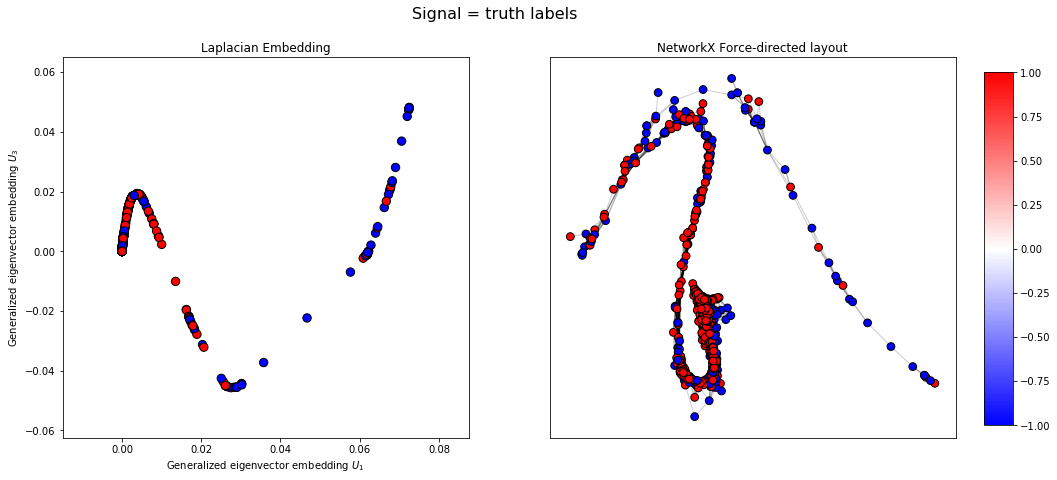

In [27]:
coplot_network_signal(labels_conn, title='Signal = truth labels')

In [28]:
accurary_ht=np.zeros((10))
for i in range(0,10):
    mn_ratio = 0.3
    w = np.random.binomial(n=1, p=mn_ratio, size=n_nodes)
    m = sum(w) # Number of measurements
    #print('Sampled {} out of {} nodes'.format(m, n_nodes))
    labels_conn=np.array(labels[list(list_comp)])
    subsampled = labels_conn*w
    #subsampled.shape
    z_heat_denoised = graph_filter(subsampled, heat_kernel, t=0.1)
    z_heat_denoised[z_heat_denoised<0]=-1
    z_heat_denoised[z_heat_denoised>=0]=1
    wrong_pred = []
    for j in range(len(z_heat_denoised)):
        if(z_heat_denoised[j] != labels_conn[j]):
            wrong_pred.append(j)
            len(wrong_pred)
    accurary_ht[i]=( 1 - len(wrong_pred)/len(subsampled))
           

In [29]:
ideal_lp = np.ones((n_nodes,))
ideal_lp[e >= 0.9] = 0  # Low-pass filter with cut-off at lambda=0.1

In [30]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    
    return iGFT(GFT(x) * spectral_response)

In [31]:
accurary_low=np.zeros((10))
for i in range(0,10):
    mn_ratio = 0.3
    w = np.random.binomial(n=1, p=mn_ratio, size=n_nodes)
    m = sum(w) # Number of measurements
    #print('Sampled {} out of {} nodes'.format(m, n_nodes))
    labels_conn=np.array(labels[list(list_comp)])
    subsampled = labels_conn*w
    #subsampled.shape
    z_low_denoised = ideal_graph_filter(subsampled,ideal_lp)
    z_low_denoised[z_low_denoised<0]=-1
    z_low_denoised[z_low_denoised>=0]=1
    wrong_pred = []
    for j in range(len(z_low_denoised)):
        if(z_low_denoised[j] != labels_conn[j]):
            wrong_pred.append(j)
            len(wrong_pred)
    accurary_low[i]=( 1 - len(wrong_pred)/len(subsampled))
           
#coplot_network_signal(z_heat_denoised, title='Signal = Heat denoised measurements')
#print('Relative Error: {:.2f}'.format(rel_err(labels_conn, z_heat_denoised)))
score_mean_low=np.mean(accurary_low)
score_variance_low=np.std(accurary_low)